# Práctica Métodos de Simulación - Parte 2

## Elena Rivas, Teresa Grau, Ignacio Casso

**Enunciado. Simulación de sucesos discretos.**

Un taller de fabricación se dedica a procesar tres tipos de piezas, para ello el
taller consta de cuatro células de procesamiento.

En el interior de cada célula se dispone de una máquina de procesado, excepto
en la célula 3 formada por dos máquinas con las mismas características, y de un
almacén (de capacidad ilimitada).

La secuencia de fabricación de cada una de las piezas así como los tiempos de
procesado (expresados en minutos y distribuidos según una triangular) en cada
célula se muestran en la siguiente tabla:


**TODO:** Escribir tabla usando sintáxis de hml:

| A | B | C |
| --- | --- | --- |
| a | b | c |

Los tiempos entre llegadas de las piezas al taller tiene carácter aleatorio. En el
fichero llegadas.txt se proporciona una muestra de tiempos entre llegadas de
piezas. Contrástese si la distribución de dichos tiempos es normal (truncada),
weibull o exponencial y estímense los parámetros de la distribución
correspondiente.

El fichero piezas.text incluye un histórico de piezas que han llegado al taller, que
nos permitirá identificar la proporción de piezas que hay de cada uno de los tres
tipos.Los tiempos de transporte de cada pieza entre las diferentes células es de 2
minutos.

A. Suponiendo que el taller trabaja de forma ininterrumpida (hay tres turnos de
trabajadores), simular el comportamiento del sistema durante 2 meses para
estimar el tiempo mínimo, medio y máximo que tardan en fabricarse los tres
tipos de piezas, el número medio de piezas esperando en cada una de las 4
células y la proporción de tiempo que están ociosas las máquinas de
procesado de las células.

B. Calcular las medidas anteriores si el tiempo de transporte de las piezas entre
las distintas células se reduce la mitad.

En caso de que fuese posible disponer de una máquina de procesado adicional,
¿en qué célula sería más beneficioso ponerla?

## Distribución de los tiempos de llegada

En primer lugar comprobamos si los tiempos de llegada proporcionados en el fichero `llegadas.txt` siguen una distribución normal truncada, weibull o exponencial, y estimar los parámetros correspondientes. Para ello podemos usar los contrastes de hipótesis vistos en clase, en concreto el contraste de ***Kolmogorov-Smirnov***.

En estadística, la prueba de *Kolmogórov-Smirnov* (también prueba K-S) es una prueba no paramétrica que determina la bondad de ajuste de dos distribuciones de probabilidad entre sí. Consiste en lo siguiente:

Deseamos contrastar la hipotesis
    H0: Fn(x) = F0(x) **TODO**
Para ello, utilizamos el estadístico de contraste
    **#imagen captura1_sm TODO**
donde:
* xi es el i-ésimo valor observado en la muestra (cuyos valores se han ordenado previamente de menor a mayor).
* ^Fn(xi) es un estimador de la probabilidad de observar valores menores o iguales que xi.
* F0(xi) es la probabilidad de observar valores menores o iguales que xi cuando H0 es cierta.

Así pues, D es la mayor diferencia absoluta observada entre la frecuencia acumulada observada ^Fn(xi) y la frecuencia acumulada teórica F0(xi), obtenida a partir de la distribución de probabilidad que se especifica como hipótesis nula.

Si los valores observados ^Fn(xi) son similares a los esperados F0(xi), el valor de D será pequeño. Cuanto mayor sea la discrepancia entre la distribución empírica ^Fn(xi) y la distribución teórica F0(xi), mayor será el valor de D.

In [3]:
import numpy as np
import random
import queue
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest

In [4]:
archivo_llegadas = open('./E1.llegadas.txt', 'r')
llegadas = [float(line) for line in archivo_llegadas.readlines()]
archivo_llegadas.close()

In [5]:
archivo_piezas = open('./E1.piezas.txt', 'r')
piezas = [int(line) for line in archivo_piezas.readlines()]
archivo_piezas.close()

Con el paquete estadístico `stats` de la librería `scipy` de Python podemos contrastar la distribución de nuestra muestra con la prueba de ***Kolmogorov***.

In [6]:
from scipy.stats import expon, exponweib, truncnorm

middle = len(llegadas)//2 #TODO: no lo usamos

llegadas1, llegadas2 = llegadas[:middle], llegadas[middle:]

Comenzamos testando la distribución exponencial. Según la documentación del paquete `stats`, la función de densidad de la exponencial es:
\[f(x) = \exp(-x)\] para x>=0.
La densidad de probabilidad anterior se define en la forma "estandarizada". Para cambiar y/o escalar la distribución, utilizamos los parámetros `loc` y `scale`. Específicamente, `expon.pdf (x, loc, scale)` (probability density function), que es equivalente a `expon.pd(y) / scale` con `y = (x - loc) / scale`.

Una parametrización común de la exponencial es en términos del parámetro *lambda*, tal que `pdf = lambda * exp (-lambda * x)`. Esta parametrización corresponde a usar `scale = 1/lambda`.

Para realizar el contraste con la librería `stats` primero necesitamos estimar los parametros que corresponderían a nuestra muestra para la distribución que queremos contrastar. Para esta tarea, `stats` cuenta con el método `scipy.stats.rv_continuous.fit`.

Éste devuelve los *MLE* para los parámetros de forma (si corresponde), ubicación y escala a partir de la muestra. MLE significa Estimación de máxima verosimilitud (Maximum Likelihood Estimate).
Hay que tener en cuenta que `fit` se calcula al maximizar una función *log-likehood*, aplicando una penalización para muestras fuera del rango de distribución. No se garantiza que la respuesta devuelta sea el MLE globalmente óptimo, puede que solo sea óptimo local o la optimización puede fallar por completo.

Una vez estimados los parametros de la exponencial, ya podemos utilizar el método `scipy.stats.kstest` que ejecuta la prueba de Kolmogorov-Smirnov para comprobar la bondad del ajuste. Que devuelve el valor del estadístico *D* y un *p-valor*.

La decisión de aceptar o rechazar la hipotesis es tomada a partir de este *p-valor*. Si el *p-valor* es grande significa  que, siendo cierta la hipótesis nula, el valor observado del estadístico *D* era  esperable, y por tanto, no hay razón para rechazar la hipótesis. Asimismo, si el *p-valor* es pequeño, indica que, siendo cierta la hipótesis nula, es muy difícil que se produjera el valor de *D* que efectivamente se ha observado. Ello obliga a poner muy en duda, y  por tanto a rechazar la hipótesis nula.

Ya podemos testar la distribución exponencial:

In [7]:
loc, scale = expon.fit(llegadas)

# kstest(llegadas, lambda x : expon.cdf(x, loc = loc, scale = scale))

kstest(llegadas,'expon', (loc, scale))

KstestResult(statistic=0.010470714624899208, pvalue=0.64335948653523267)

Hipotesis no rechazada. Los párametros serían:

In [8]:
print((loc, scale))

(0.0011736909087417102, 12.996337543335594)


A continuación testamos la distribución de weibull, que según la documentación de `stats` tiene la siguiente funcion de distribución:
**#imagen captura2_sm TODO**

*a* y *c* son parámetros de forma. La densidad de probabilidad anterior se define en la forma "estandarizada". Para cambiar y/o escalar la distribución, al igual que explicamos antes en la exponencial, se utilizan los parametros *loc* y *scale*. Concretamente, `exponweib.pdf(x, a, c, loc, scale)`, que es equivalente a `exponweib.pdf(y, a, c) / scale` con `y = (x - loc) / scale.`

In [13]:
params = exponweib.fit(llegadas, fa=1) # an exponential weibull with a = 1 is the normal weibull
#params = exponweib.fit(llegadas)
#kstest(llegadas, lambda x : exponweib.cdf(x, a = 1, c= c, loc = loc, scale = scale))

kstest(llegadas,'exponweib', args=params)


KstestResult(statistic=0.0090628755311315534, pvalue=0.80604772543015868)

Hypotesis not rejected

In [14]:
print(params)

(1, 0.98351789950351987, 0.0011736909999999997, 12.916844528285321)


Tampoco rechaza la hipotesis de que nuestra muestra siga una distribución Weibull. Esto podemos explicarlo observando los parametros que obtenemos con la funcion `fit`. Observamos que el parametro *c* es casi 1, cuando se da esto lo que en realidad tenemos es una exponencial. Por eso la hipotesis no es rechazada.

***However we see that the paramenter k of the distribution is estimated to be 0.98, and with k = 1 we actually have an exponential, so that's why it is not rejected #TODO: quitar***

Y por último testamos la distribución normal truncada:

In [13]:
from scipy.stats import truncnorm

a,b,loc,scale = truncnorm.fit(llegadas)

# The bounds are given w.r.t the standard distribution, prior to applying scale and location paramenters.
# Therefore we can't specify that the lower bound is 0 (fa=0). The information we have is that
# a = -loc, but that is a constraint we can not pass to the method fit. To satisfy the constraint, we propose
# the following fixpoint

while abs(loc+a) > 0.0001:
    a,b,loc,scale = truncnorm.fit(llegadas, fa=-loc)
    
# just needs one iteration

kstest(llegadas,'truncnorm', (a,b,loc,scale))

/home/ignacio/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5823: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/home/ignacio/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5823: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


KstestResult(statistic=0.16126924639176748, pvalue=2.2424395794550417e-113)

La hipotesis es rechazada. Por tanto, nuestra muestra sigue una distribución exponencial con los siguientes parametros `loc` y `scale`:

In [15]:
loc, scale = expon.fit(llegadas)
print((loc, scale))

(0.0011736909087417102, 12.996337543335594)


A continuación visualizamos la distribución de nuestra muestra mediante un histograma:

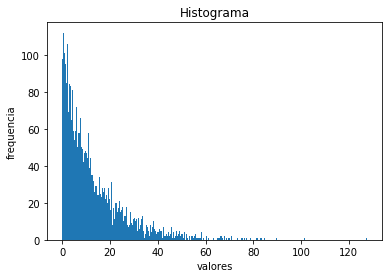

In [17]:
# histograma de llegadas
cuenta, cajas, ignorar = plt.hist(llegadas, 500)
plt.ylabel('frequencia')
plt.xlabel('valores')
plt.title('Histograma')
plt.show()

### Distribución de las piezas

In [3]:
#cantidad de piezas de cada tipo
stats.itemfreq(piezas)

array([[   1, 1254],
       [   2, 2407],
       [   3, 1339]])

## Simulación del Sistema

A continuación simulamos el sistema...

Asumimos FIFO para cada celula de procesamiento...

Usamos los tiempos de llegada y las piezas de los ficheros (aunque tambien podriamos generarlos aleatoriamente, conociendo su distribucion)...
**TODO:** Usar un generador aleatorio? Implementarlo nosotros?

Usamos numpy.random.triangular para generar tiempos de procesado aleatorio...
**TODO:** Implementarlo nosotros?

En primer lugar escribimos los generadores de tiempos y piezas...

In [15]:
import numpy as np
import random
import queue
import math

In [16]:
# times = [1,2,200]

def genArrival():
    return np.random.exponential(13)
    # debug
    global times
    time = times[0]
    times = times[1:]
    return time

In [17]:
def genPieceType():
    x = np.random.random()
    if x < 0.2508: # 1254/5000
        return 1
    elif x < 0.7322: # (1254+2407)/5000
        return 2
    else: # x < 1 (1254+2407+1339)
        return 3
# TODO: use 0.25, 0.5, 0.25 instead?

In [33]:
class System():
    
    def __init__(self, transportTime, num_machines):
        self.eventsQueue = queue.PriorityQueue()
        
        #if debug:
        #    self.arrivals = open("E1.llegadas.txt","r")
        #    self.pieces = open("E1.piezas.txt","r")
        # open files
        
        # fabrication sequence for each type of piece
        self.steps = [[0,1,2,3],
                      [0,1,3,1,2],
                      [1,0,2]]
        
        # processing times for each type of piece at each step of its phabrication sequence
        self.processingTimes =[[(6,9,10), (5,8,10), (15,20,25), (8,12,16)],
                           [(1,13,15), (4,6,8), (15,18,21), (6,9,12), (27,30,39)], # El 30 es un 3 en el enunciado, errata
                           [(7,9,11), (7,10,13), (18,23,28)]]
        
        
        # cell queues
        self.queue = [queue.Queue(),queue.Queue(),queue.Queue(),queue.Queue()]
        
        # number of machines in each cell
        self.num_machines = num_machines
        
        # number of idle machines in each clell
        self.idle_machines = num_machines[:] # copy
        
        # transportation time between cells
        self.transportTime = transportTime
        
        # stats counters
        self.minTime = [math.inf, math.inf, math.inf] # min processing type of each type of piece
        self.maxTime = [0,0,0] # max processing type of each type of piece
        self.sumTimes = [0,0,0] # Sum of the processing times of all pieces for each type of piece
        self.numPieces = [0,0,0] # Total number of pieces processed for each type of piece
        
        self.queueSizeOverTime = [0,0,0,0] # like the area under the integral of the size of each queue over time, but discrete
        self.lastUpdate = [0,0,0,0] # Last time the previous counter was updated
        
        self.idleTime = [0,0,0,0] # total time the machine(s) in a cell have been idle
        self.lastUpdateMachine = [0,0,0,0] # Last time the previous counter was updated
        
        self.debug = False
        
    # destructor
        # close files

    def simul_main(self,simulationTime):
    
        self.time = 0
        
        self.simulationTime = simulationTime
        
        self.nextPiece()
    
        while not self.eventsQueue.empty():
            self.time, _, nextEvent = self.eventsQueue.get()
            nextEvent()
            
    def simul_main_debug(self, simulationTime):
            
        self.time = 0
    
        self.simulationTime = simulationTime
    
        self.nextPiece()
            
    def debug_step(self):
        
        if not self.eventsQueue.empty():
            self.time, eventDescription, nextEvent = self.eventsQueue.get()
            print(self.time)
            print(eventDescription)
            nextEvent()
        
    def nextPiece(self):
        nextArrival = self.timeTillNextArrival()
        nextArrivalTime = self.time + nextArrival
        if nextArrivalTime < self.simulationTime:
            nextPieceType = self.nextPieceType()
            nextPiece = (nextArrivalTime, nextPieceType, 0)
            #eventsQueue.put(self.advancePiece(nextPiece), nextArrivalTime)
            #eventsQueue.put(self.nextPiece(), nextArrivalTime)
            # The prority queue as it is breaks if two events happen at the same time
            eventDescription = "piece " + str(nextPiece) + " arrives"
            event = lambda : self.arrivePiece(nextPiece)
            self.eventsQueue.put((nextArrivalTime, eventDescription, event))
    
    def arrivePiece(self,piece):
        self.nextPiece()
        self.advancePiece(piece)
        
    def nextPieceType(self):
        #if debug:
        #    piece = self.pieces.readline()
        #    return int(piece)-1
        #else:
            return genPieceType()-1
        # Types of pieces are shifted so that the first one is 0
        
    def timeTillNextArrival(self):
        #if debug:
        #    arrival = self.arrivals.readline()
        #    return float(arrival)
        #else:
            return genArrival()
    
    def advancePiece(self,piece):
        
        arrivalTime, pieceType, step = piece

        if self.steps[pieceType][step:] == []:
            self.finishPiece(piece)
            if self.debug:
                print("piece " + str(arrivalTime) + " finishes")
        else:
            next_cell = self.steps[pieceType][step]
            if step == 0:
                self.enter(next_cell,piece)
            else:
                eventTime = self.time + self.transportTime
                eventDescription = "piece " + str(piece) + " enters cell " + str(next_cell)
                event = lambda : self.enter(next_cell,piece)
                self.eventsQueue.put((eventTime, eventDescription, event))
    
    def finishPiece(self,piece):
        
        arrivalTime, pieceType, _ = piece
        
        totalTime = self.time - arrivalTime
        
        if totalTime < self.minTime[pieceType]: # use dictionaries, since index needs shifting
            self.minTime[pieceType] = totalTime
       
        if totalTime > self.maxTime[pieceType]:
            self.maxTime[pieceType] = totalTime
        
        self.sumTimes[pieceType] += totalTime
        
        self.numPieces[pieceType] += 1
        
    
    def enter(self,cell,piece):
        
        if self.idle_machines[cell] > 0:
            self.process(cell,piece)
        else:
            self.queueSizeOverTime[cell] += self.queue[cell].qsize()*(self.time-self.lastUpdate[cell])
            self.lastUpdate[cell] = self.time
            self.queue[cell].put(piece)

    def process(self,cell,piece):
        
        self.idleTime[cell] += (self.time - self.lastUpdateMachine[cell])*self.idle_machines[cell]
        self.lastUpdateMachine[cell] = self.time
        
        _, pieceType, step = piece
        
        low, mode, upp = self.processingTimes[pieceType][step]
        
        if self.debug:
            processing_time = mode
        else:
            processing_time = np.random.triangular(low,mode,upp)
        
        
        self.idle_machines[cell] -= 1
        
        eventDescription = "piece " + str(piece) + " done in cell " + str(cell)
        self.eventsQueue.put((self.time+processing_time, eventDescription, lambda : self.done(cell,piece)))
        
    def done(self,cell,piece):
        
        self.idle_machines[cell] += 1
        
        if self.queue[cell].empty():
            
            self.lastUpdateMachine[cell] = self.time
                   
        else:
            
            self.queueSizeOverTime[cell] += self.queue[cell].qsize()*(self.time-self.lastUpdate[cell])
            self.lastUpdate[cell] = self.time
            nextPiece = self.queue[cell].get()
            self.process(cell,nextPiece)
        
        arrivalTime, pieceType, step = piece
        piece = arrivalTime, pieceType, step + 1
        self.advancePiece(piece)

In [37]:
system = System(2,[1,1,2,1])
system.simul_main_debug(100)

In [38]:
system.debug = True

In [39]:
for _ in range(100):
    system.debug_step()

12.11178981618215
piece (12.11178981618215, 1, 0) arrives
25.11178981618215
piece (12.11178981618215, 1, 0) done in cell 0
27.11178981618215
piece (12.11178981618215, 1, 1) enters cell 1
33.11178981618215
piece (12.11178981618215, 1, 1) done in cell 1
35.11178981618215
piece (12.11178981618215, 1, 2) enters cell 3
41.31089908024262
piece (41.31089908024262, 2, 0) arrives
47.20842860916076
piece (47.20842860916076, 1, 0) arrives
50.31089908024262
piece (41.31089908024262, 2, 0) done in cell 1
52.31089908024262
piece (41.31089908024262, 2, 1) enters cell 0
53.11178981618215
piece (12.11178981618215, 1, 2) done in cell 3
55.11178981618215
piece (12.11178981618215, 1, 3) enters cell 1
60.20842860916076
piece (47.20842860916076, 1, 0) done in cell 0
62.20842860916076
piece (47.20842860916076, 1, 1) enters cell 1
63.41393621218169
piece (63.41393621218169, 2, 0) arrives
64.11178981618215
piece (12.11178981618215, 1, 3) done in cell 1
66.11178981618215
piece (12.11178981618215, 1, 4) enters c

In [8]:
system.time

86384.91734354805

In [9]:
system.minTime

[inf, inf, 46.0]

In [10]:
system.maxTime

[0, 0, 46.0]

In [11]:
system.sumTimes

[0, 0, 46.0]

In [12]:
[system.sumTimes[i]/system.numPieces[i] for i in range(3)]

ZeroDivisionError: division by zero

In [13]:
system.numPieces

[0, 0, 1]

In [250]:
system.queueSizeOverTime

[0, 0, 0, 0]

In [251]:
[system.queueSizeOverTime[i]/system.time for i in range(4)]

[0.0, 0.0, 0.0, 0.0]

In [252]:
system.idleTime # TODO: fix

[832.6736934616771, 827.4331821415414, 1485.9400048702266, 0]

### Apartado A: Tiempo de transporte = 2 min.

In [40]:
system = System(2,[1,1,2,1])
system.simul_main(86400) # 2 months

In [41]:
system.time

88761.59960588154

In [42]:
system.minTime

[71.21482780633096, 89.38205576779889, 49.97424599476568]

In [43]:
system.maxTime

[2423.64649525765, 2757.2611115291365, 2421.926683951693]

In [44]:
system.sumTimes

[2383050.207931501, 4766525.126049586, 2297081.06028133]

In [45]:
[system.sumTimes[i]/system.numPieces[i] for i in range(3)]

[1407.5901996051393, 1465.2705582691626, 1342.5371480311687]

In [46]:
system.numPieces

[1693, 3253, 1711]

In [47]:
system.queueSizeOverTime

[78563.07816563916, 249014.31288279485, 8351920.199934405, 328124.8471109644]

In [48]:
[system.queueSizeOverTime[i]/system.time for i in range(4)]

[0.8851020994943111, 2.8054284058474157, 94.09384505257371, 3.6966982182374073]

In [49]:
system.idleTime # TODO: fix

[68848.28091819512, 76623.89639972759, 88731.43893006715, 80413.26636371735]

### Apartado B: Tiempo de transporte = 1 min.

In [ ]:
system = System(1,[1,1,2,1])
system.simulate()
system.showStats()

## Máquina de procesado adicional

Habrá que definir beneficio. Consideramos solo el tiempo?

In [ ]:
np.random.seed()

In [ ]:
system = System(2,[2,1,2,1])
system.simulate()
system.showStats()

In [ ]:
system = System(2,[1,2,2,1])
system.simulate()
system.showStats()

In [ ]:
system = System(2,[1,1,3,1])
system.simulate()
system.showStats()

In [ ]:
system = System(2,[1,1,2,2])
system.simulate()
system.showStats()